## 6.1.3 VGGNet

In [80]:
# 데이터 불러오기
from google.colab import files
file_uploaded=files.upload()

Saving catanddog.zip to catanddog.zip


In [81]:
# catanddog 폴더에 압축 풀기
!unzip catanddog.zip -d data/catanddog/

Archive:  catanddog.zip
replace data/catanddog/test/Cat/8104.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/catanddog/test/Cat/8104.jpg  
  inflating: data/catanddog/test/Cat/8105.jpg  
  inflating: data/catanddog/test/Cat/8106.jpg  
  inflating: data/catanddog/test/Cat/cat.12426.jpg  
  inflating: data/catanddog/test/Cat/cat.12495.jpg  
  inflating: data/catanddog/test/Cat/cat.12496.jpg  
  inflating: data/catanddog/test/Dog/dog.116.jpg  
  inflating: data/catanddog/test/Dog/dog.212.jpg  
  inflating: data/catanddog/test/Dog/dog.213.jpg  
  inflating: data/catanddog/test/Dog/dog.214.jpg  
  inflating: data/catanddog/test/Dog/dog.215.jpg  
  inflating: data/catanddog/test/Dog/dog.224.jpg  
  inflating: data/catanddog/train/Cat/0.jpg  
  inflating: data/catanddog/train/Cat/1.jpg  
  inflating: data/catanddog/train/Cat/10.jpg  
  inflating: data/catanddog/train/Cat/11.jpg  
  inflating: data/catanddog/train/Cat/12.jpg  
  inflating: data/catanddog/train/Cat/13.jpg  
  inf

In [82]:
# 필요한 라이브러리 호출
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [83]:
# VGG 모델 정의
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        self.features = features #VGG 모델에 대한 매개변수에서 받아 온 features 값을 self.features에 넣기
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        ) #완전연결층과 출력층 정의

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [84]:
# 모델 유형 정의
#VGG11: 합성곱층*8+풀링층*3=전체 11 계층
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
#VGG13: 합성곱층*10+풀링층*3=전체 13 계층
vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
#VGG16: 합성곱층*13+풀링층*3=전체 16 계층
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512,
                512, 'M']
#VGG19: 합성곱층*16+풀링층*3=전체 19 계층
vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
                512, 512, 512, 512, 'M']

In [85]:
# VGG 계층 정의
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3

    for c in config: #vgg11_config 값을 가져옴
        assert c == 'M' or isinstance(c, int)
        if c == 'M': #불러온 값이 M이면 MaxPool2d 적용
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else: #불러온 값이 숫자이면 Conv2d 적용
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm: #배치 정규화를 적용할지: 적용 시 배치 정규화, ReLU
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            else: #적용하지 않을 시 ReLU만 적용
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = c

    return nn.Sequential(*layers) #네트워크의 모든 계층 반환

In [86]:
# 모델 계층 생성
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True) #배치 정규화 추가

In [87]:
# VGG11 계층 확인
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [88]:
# VGG11 전체에 대한 네트워크
OUTPUT_DIM = 2
model = VGG(vgg11_layers, OUTPUT_DIM).to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [89]:
# VGG11 사전 훈련된 모델 사용
import torchvision.models as models

pretrained_model = models.vgg11_bn(pretrained = True)
print(pretrained_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [90]:
# 이미지 데이터 전처리
train_transforms = transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [91]:
# ImageFolder를 이용하여 데이터셋 불러오기
#훈련.테스트 데이터셋이 위치한 경로
train_path = 'data/catanddog/train'
test_path = 'data/catanddog/test'

train_dataset = torchvision.datasets.ImageFolder(
    train_path,
    transform=train_transforms
)
test_dataset = torchvision.datasets.ImageFolder(
    test_path,
    transform=test_transforms
)

print(len(train_dataset)), print(len(test_dataset))

529
12


(None, None)

In [92]:
# 훈련과 검증 데이터 분할
VALID_RATIO = 0.9
n_train_examples = int(len(train_dataset) * VALID_RATIO) #전체 훈련 데이터 중 90%를 훈련 데이터셋으로 사용
n_valid_examples = len(train_dataset) - n_train_examples #전체 훈련 데이터 중 10%를 검증 데이터셋으로 사용

train_data, valid_data = data.random_split(train_dataset,
                                           [n_train_examples, n_valid_examples])

In [93]:
# 검증 데이터 전처리
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [94]:
# 훈련, 검증, 테스트 데이터셋 수 확인
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 476
Number of validation examples: 53
Number of testing examples: 12


In [95]:
# 메모리로 데이터 불러오기
BATCH_SIZE = 32 # OutOfMemoryError로 32로 줄임
train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE) #훈련 데이터셋을 임의로 섞어서 가져오기

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_dataset,
                                batch_size = BATCH_SIZE)

In [96]:
# 옵티마이저와 손실 함수 정의
optimizer = optim.Adam(model.parameters(), lr = 1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [97]:
# 모델 정확도 측정 함수
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [98]:
# 모델 학습 함수 정의
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [99]:
# 모델 성능 측정 함수
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [100]:
# 학습 시간 측정 함수
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [101]:
# 모델 학습
import time

EPOCHS = 5
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    #훈련 데이터셋을 모델에 적용한 결과(오차와 정확도)를 train_loss와 train_acc에 저장
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    #검증 데이터셋을 모델에 적용한 결과(오차와 정확도)를 valid_loss와 valid_acc에 저장
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss: #valid_loss가 가장 작은 값을 구하고 그 상태의 모델을 VGG-model.pt로 저장
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'data/VGG-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time) #모델 훈련에 대한 시작.종료 시간 저장

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Valid. Loss: {valid_loss:.3f} |  Valid. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 0.702 | Train Acc: 49.23%
	 Valid. Loss: 0.695 |  Valid. Acc: 37.72%
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.707 | Train Acc: 48.84%
	 Valid. Loss: 0.698 |  Valid. Acc: 37.72%
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.687 | Train Acc: 53.72%
	 Valid. Loss: 0.705 |  Valid. Acc: 34.60%
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.683 | Train Acc: 54.49%
	 Valid. Loss: 0.708 |  Valid. Acc: 36.16%
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.699 | Train Acc: 49.82%
	 Valid. Loss: 0.710 |  Valid. Acc: 36.16%


In [102]:
# 테스트 데이터셋을 이용한 모델 성능 측정
model.load_state_dict(torch.load('data/VGG-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

<ipython-input-102-3b932d3fcb2c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('data/VGG-model.pt'))


Test Loss: 0.693 | Test Acc: 50.00%


In [103]:
# 테스트 데이터셋을 이용한 모델의 예측 확인 함수
def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    return images, labels, probs

In [104]:
# 예측 중에서 정확하게 예측한 것을 추출
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels) # 예측과 정답이 같은지 비교
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if correct:
        correct_examples.append((image, label, prob))

correct_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [105]:
# 이미지 출력을 위한 전처리
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max) # torch.clamp는 주어진 최소.최대의 범주에 이미지가 위치하도록 함
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [106]:
# 모델이 정확하게 예측한 이미지 출력 함수
def plot_most_correct(correct, classes, n_images, normalize = True):
    rows = int(np.sqrt(n_images)) #np.sqrt:제곱근을 계산(0.5를 거듭제곱)
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (25, 20))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1) #출력하는 그래프 개수만큼 subplot을 만듦
        image, true_label, probs = correct[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        correct_class = classes[correct_label]

        if normalize: #본래 이미지대로 출력하기 위해 normalize_image 함수 호출
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {correct_class} ({correct_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace = 0.4)

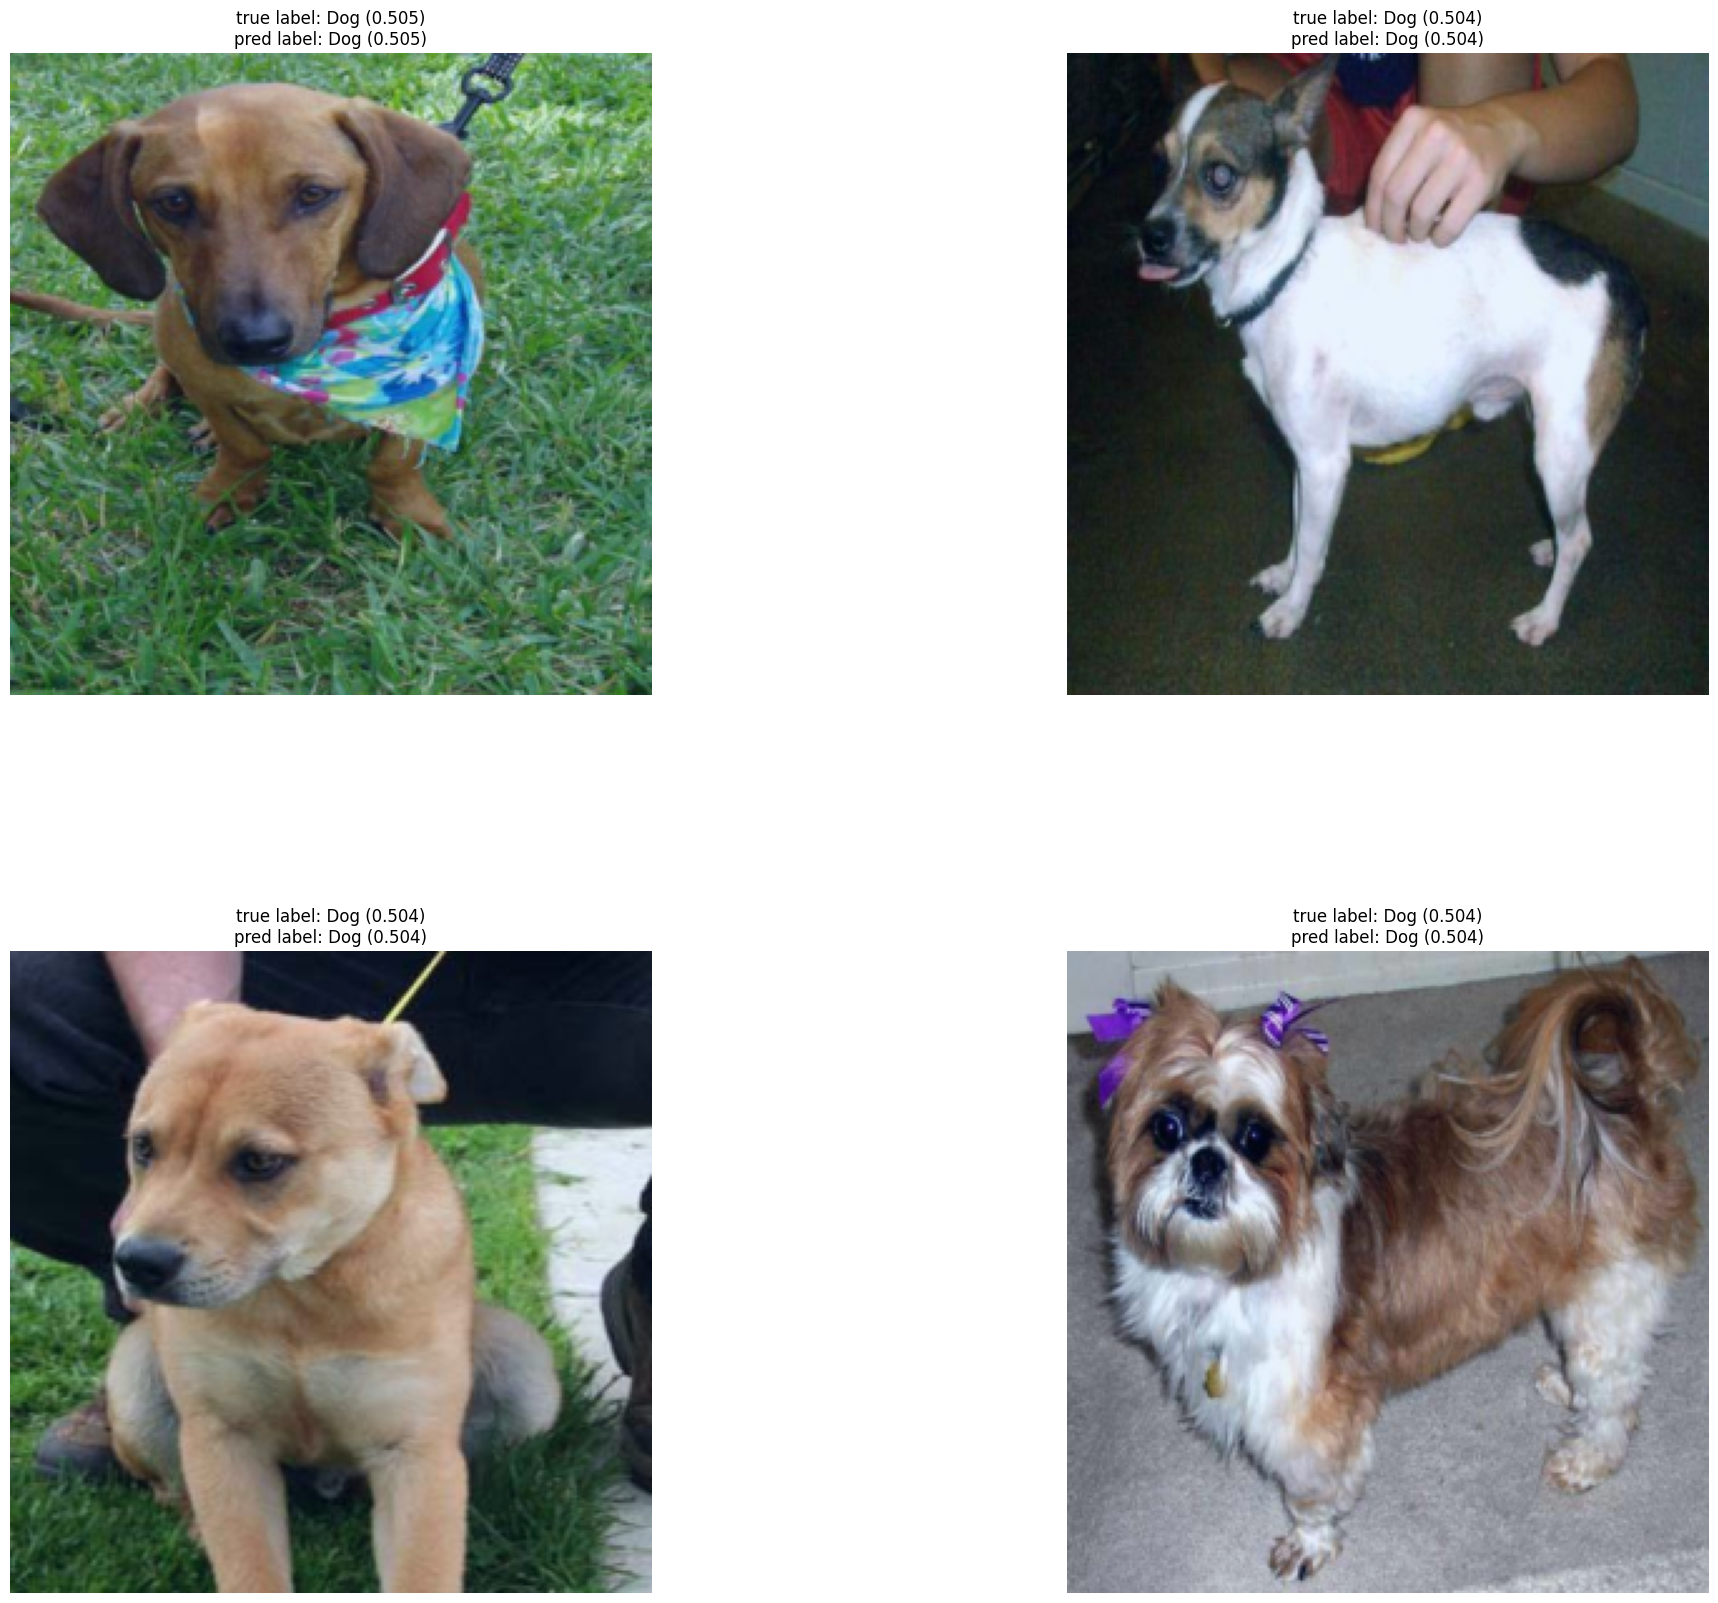

In [107]:
#예측 결과 이미지 출력
classes = test_dataset.classes
N_IMAGES = 5
plot_most_correct(correct_examples, classes, N_IMAGES)